# Combinig the dataset and Modeling

<img src="All_Articles.jpg">

In [1]:
import pandas as pd
from collections import Counter
import re
import numpy as np
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.metrics import f1_score, accuracy_score , recall_score , precision_score
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/Yemre/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Reading NYT dataset
df_nyt = pd.read_csv("/Users/Yemre/Desktop/News_Data_Mix/NYT_Combined_Clean_APR_4_No_Slash.csv")

In [3]:
# Adding label to real news to the dataset and showing the column names
df_nyt["fakeness"] = 0
df_nyt.columns

Index([u'Unnamed: 0', u'index', u'_id', u'body', u'keywords',
       u'lead_paragraph', u'pub_date', u'section_name', u'word_count',
       u'head_clean', u'fakeness'],
      dtype='object')

In [4]:
# Reading The Guardian dataset
df_tguard = pd.read_csv("/Users/Yemre/Desktop/News_Data_Mix/Clean_TheGuardian_Combined_No_Slash.csv")

In [5]:
# Adding label to real news to the dataset and showing the column names
df_tguard["fakeness"] = 0
df_tguard.columns

Index([u'Unnamed: 0', u'Unnamed: 0.1', u'apiUrl', u'fields', u'id',
       u'isHosted', u'sectionId', u'sectionName', u'type',
       u'webPublicationDate', u'webTitle', u'webUrl', u'bodyText', u'headline',
       u'fakeness'],
      dtype='object')

In [6]:
df_fake = pd.read_csv("/Users/Yemre/Desktop/News_Data_Mix/FakeNews_Clean_All.csv")

In [7]:
# Label was there for fake news dataset and showing the column names
df_fake.columns

Index([u'Unnamed: 0', u'uuid', u'ord_in_thread', u'published', u'title',
       u'text', u'language', u'crawled', u'site_url', u'country',
       u'thread_title', u'spam_score', u'replies_count', u'participants_count',
       u'likes', u'comments', u'shares', u'type', u'fakeness'],
      dtype='object')

In [8]:
# Changing the name of the column for concating later
df_tguard = df_tguard.rename(columns={'bodyText' : 'body','webPublicationDate':'pub_date'})
df_nyt = df_nyt.rename(columns={'head_clean':'headline','_id':'id'})
df_fake = df_fake.rename(columns={'text':'body','title':'headline','uuid':'id','published':'pub_date'})
df_fake.columns,df_nyt.columns,df_tguard.columns

(Index([u'Unnamed: 0', u'id', u'ord_in_thread', u'pub_date', u'headline',
        u'body', u'language', u'crawled', u'site_url', u'country',
        u'thread_title', u'spam_score', u'replies_count', u'participants_count',
        u'likes', u'comments', u'shares', u'type', u'fakeness'],
       dtype='object'),
 Index([u'Unnamed: 0', u'index', u'id', u'body', u'keywords', u'lead_paragraph',
        u'pub_date', u'section_name', u'word_count', u'headline', u'fakeness'],
       dtype='object'),
 Index([u'Unnamed: 0', u'Unnamed: 0.1', u'apiUrl', u'fields', u'id',
        u'isHosted', u'sectionId', u'sectionName', u'type', u'pub_date',
        u'webTitle', u'webUrl', u'body', u'headline', u'fakeness'],
       dtype='object'))

In [9]:
# Dropping unnecesary columns
df_fake.drop([u'Unnamed: 0', u'ord_in_thread', 
         u'language', u'crawled', u'site_url', u'country',
        u'thread_title', u'spam_score', u'replies_count', u'participants_count',
        u'likes', u'comments', u'shares', u'type'],inplace=True,axis=1)

df_nyt.drop([u'Unnamed: 0', u'index',  u'keywords',
        u'lead_paragraph', u'section_name', u'word_count'],inplace=True,axis=1)

df_tguard.drop([u'Unnamed: 0', u'Unnamed: 0.1', u'apiUrl', u'fields', 
        u'isHosted', u'sectionId', u'sectionName', u'type',
         u'webTitle', u'webUrl'],inplace=True,axis=1)

In [10]:
# Overview for data
df_fake.head()

,id,pub_date,headline,body,fakeness
0,6a175f46bcd24d39b3e962ad0f29936721db70db,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Govt Be...,Print They should pay all the back all the mon...,1
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,1
2,c70e149fdd53de5e61c29281100b9de0ed268bc3,2016-10-31T01:41:49.479+02:00,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : Fox News Sunday reported this morn...,1
3,7cf7c15731ac2a116dd7f629bd57ea468ed70284,2016-11-01T05:22:00.000+02:00,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,1
4,0206b54719c7e241ffe0ad4315b808290dbe6c0f,2016-11-01T21:56:00.000+02:00,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,1


In [11]:
# Overview for data
df_nyt.head()

,id,body,pub_date,headline,fakeness
0,58cdc49095d0e02489b91df4,Reaction to the death of rock 'n' roll legend ...,2017-03-18T23:36:42+0000,"u""Reaction to the Death of Rock n Roll Legend ...",0
1,58cdc32295d0e02489b91df3,BERLIN Angela Merkel's conservatives have a ...,2017-03-18T23:30:34+0000,"u""Merkels Conservatives Just Ahead of Social D...",0
2,58cdc05395d0e02489b91dee,FRANKFURT A large Porsche SE stake owned by ...,2017-03-18T23:18:34+0000,uPiech Porsche SE Stake May Be Sold by End May...,0
3,58cdbf9795d0e02489b91ded,FRANKFURT Munich prosecutors searched the of...,2017-03-18T23:15:28+0000,uVW CEO Offices Searched in Audi Investigation...,0
4,58cdbee795d0e02489b91dec,CAIRO Egyptian President Abdel Fattah al-Sis...,2017-03-18T23:12:28+0000,"u""Egypts Sisi to Visit Washington in First Wee...",0


In [12]:
# Overview for data
df_tguard.head()

,id,pub_date,body,headline,fakeness
0,business/2015/dec/31/value-of-gun-manufacturer...,2015-12-31T21:33:28Z,Stock markets around the world closed down on ...,Value of gun manufacturers' stocks almost doub...,0
1,us-news/2015/dec/31/the-counted-police-killing...,2015-12-31T20:00:20Z,Young black men were nine times more likely th...,Young black men killed by US police at highest...,0
2,us-news/2015/dec/31/the-counted-killings-by-po...,2015-12-31T20:00:20Z,"At the beginning of 2015, the Guardian began a...",The Guardian view on killings by US police: wh...,0
3,us-news/2015/dec/31/animal-themed-condoms-slow...,2015-12-31T19:55:06Z,Environmentalists will ramp up their attempts ...,Animal-themed condoms aim to slow population g...,0
4,world/2015/dec/31/archbishop-and-mps-wrote-in-...,2015-12-31T19:45:22Z,Letters written by a former archbishop of Cant...,Archbishop and MPs wrote in support of bishop ...,0


In [13]:
# Concat the datasents
df_all = df_fake.append(df_tguard, ignore_index=True)
df_all = df_all.append(df_nyt,ignore_index=True)

In [14]:
#Dropping the Nan values and info
df_all.dropna(inplace=True)
print df_all.shape
df_all.info()

(52055, 5)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 52055 entries, 0 to 52110
Data columns (total 5 columns):
body        52055 non-null object
fakeness    52055 non-null int64
headline    52055 non-null object
id          52055 non-null object
pub_date    52055 non-null object
dtypes: int64(1), object(4)
memory usage: 2.4+ MB


In [15]:
df_all.head()

,body,fakeness,headline,id,pub_date
0,Print They should pay all the back all the mon...,1,Muslims BUSTED: They Stole Millions In Govt Be...,6a175f46bcd24d39b3e962ad0f29936721db70db,2016-10-26T21:41:00.000+03:00
1,Why Did Attorney General Loretta Lynch Plead T...,1,Re: Why Did Attorney General Loretta Lynch Ple...,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,2016-10-29T08:47:11.259+03:00
2,Red State : Fox News Sunday reported this morn...,1,BREAKING: Weiner Cooperating With FBI On Hilla...,c70e149fdd53de5e61c29281100b9de0ed268bc3,2016-10-31T01:41:49.479+02:00
3,Email Kayla Mueller was a prisoner and torture...,1,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,7cf7c15731ac2a116dd7f629bd57ea468ed70284,2016-11-01T05:22:00.000+02:00
4,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,1,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,0206b54719c7e241ffe0ad4315b808290dbe6c0f,2016-11-01T21:56:00.000+02:00


In [16]:
df_all.to_csv("/Users/Yemre/Desktop/Complete_DataSet_Clean.csv")

# Modeling

In [17]:
# Preparing the target and predictors for modeling

X_body_text = df_all.body.values
X_headline_text = df_all.headline.values
y = df_all.fakeness.values

In [18]:
tfidf = TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS,ngram_range=(1,2),max_df= 0.85, min_df= 0.01)

In [19]:
X_body_tfidf = tfidf.fit_transform(X_body_text)
X_headline_tfidf = tfidf.fit_transform (X_headline_text)

In [20]:
X_headline_tfidf_train, X_headline_tfidf_test, y_headline_train, y_headline_test = train_test_split(X_headline_tfidf,y, test_size = 0.2, random_state=1234)
X_body_tfidf_train, X_body_tfidf_test, y_body_train, y_body_test = train_test_split(X_body_tfidf,y, test_size = 0.2, random_state=1234)

# Learning Curve

In [21]:
class cross_validation(object):
    '''This class provides cross validation of any data set why incrementally increasing number 
       of samples in the training and test set and performing KFold splits at every iteration. 
       During cross validation the metrics accuracy, recall, precision, and f1-score are recored. 
       The results of the cross validation are display on four learning curves. '''
    
    def __init__(self, model, X_data, Y_data, X_test=None, Y_test=None, 
                 n_splits=3, init_chunk_size = 1000000, chunk_spacings = 100000, average = "binary"):

        self.X, self.Y =  shuffle(X_data, Y_data, random_state=1234)
        
        
        self.model = model
        self.n_splits = n_splits
        self.chunk_size = init_chunk_size
        self.chunk_spacings = chunk_spacings        
        
        self.X_train = []
        self.X_test = []
        self.Y_train = []
        self.Y_test = []
        self.X_holdout = []
        self.Y_holdout = []
        
        self.f1_train = []
        self.f1_test = []
        self.acc_train = []
        self.acc_test = []
        self.pre_train = []
        self.pre_test = []
        self.rec_train = []
        self.rec_test = []
        
        self.f1_mean_train = []
        self.f1_mean_test = []
        self.acc_mean_train = []
        self.acc_mean_test = []
        self.pre_mean_train = []
        self.pre_mean_test = []
        self.rec_mean_train = []
        self.rec_mean_test = []
        
        self.training_size = []
        self.averageType = average
    
    def make_chunks(self):
        '''Partitions data into chunks for incremental cross validation'''
        
        # get total number of points
        self.N_total = self.X.shape[0]
        # partition data into chunks for learning
        self.chunks = list(np.arange(self.chunk_size, self.N_total, self.chunk_spacings ))
        self.remainder = self.X.shape[0] - self.chunks[-1]
        self.chunks.append( self.chunks[-1] + self.remainder )



    def train_for_learning_curve(self):
        '''KFold cross validates model and records metric scores for learning curves. 
           Metrics scored are f1-score, precision, recall, and accuracy'''

        # partiton data into chunks 
        self.make_chunks()
        # for each iteration, allow the model to use 10 more samples in the training set 
        self.skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=1234)
        # iterate through the first n samples
        for n_points in self.chunks: 
            
        
            # split the first n samples in k folds 
            for train_index, test_index in self.skf.split(self.X[:n_points], self.Y[:n_points]):
                self.train_index, self.test_index = train_index, test_index                
                self.X_train = self.X[self.train_index]
                self.X_test = self.X[self.test_index]
                self.Y_train = self.Y[self.train_index]
                self.Y_test = self.Y[self.test_index]
                
                self.model.fit(self.X_train, self.Y_train)
                self.y_pred_train = self.model.predict(self.X_train)
                self.y_pred_test = self.model.predict(self.X_test)
                self.log_metric_scores_()   
                
            self.log_metric_score_means_()
            self.training_size.append(n_points)
        
    def validate_for_holdout_set(self, X_holdout, Y_holdout):
        
        
        self.X_test = X_holdout
        self.Y_test = Y_holdout
        
        # partiton data into chunks 
        self.make_chunks()
        
        for n_points in self.chunks:
            
            self.X_train = self.X[:n_points]
            self.Y_train = self.Y[:n_points]

            self.model.fit(self.X_train, self.Y_train)
            self.y_pred_train = self.model.predict(self.X_train)
            self.y_pred_test = self.model.predict(self.X_test)
            self.log_metric_scores_()   

            self.log_metric_score_means_()
            self.training_size.append(n_points)
            
            
    
                            
    def log_metric_score_means_(self):
        '''Recrods the mean of the four metrics recording during training'''
        self.f1_mean_train.append(np.sum(self.f1_train)/len(self.f1_train))
        self.f1_mean_test.append(np.sum(self.f1_test)/len(self.f1_test))
        
        self.acc_mean_train.append(np.sum(self.acc_train)/len(self.acc_train))
        self.acc_mean_test.append(np.sum(self.acc_test)/len(self.acc_test))
        
        self.pre_mean_train.append(np.sum(self.pre_train)/len(self.pre_train))
        self.pre_mean_test.append(np.sum(self.pre_test)/len(self.pre_test))
        
        self.rec_mean_train.append(np.sum(self.rec_train)/len(self.rec_train))
        self.rec_mean_test.append(np.sum(self.rec_test)/len(self.rec_test))
        
        self.reinitialize_metric_lists_()
            
            
    def reinitialize_metric_lists_(self):
        '''Reinitializes metrics lists for training'''
        self.f1_train = []
        self.f1_test = []
        self.acc_train = []
        self.acc_test = []
        self.pre_train = []
        self.pre_test = []
        self.rec_train = []
        self.rec_test = []

            
    def log_metric_scores_(self):
        '''Records the metric scores during each training iteration'''
        self.f1_train.append(f1_score(self.Y_train, self.y_pred_train, average=self.averageType))
        self.acc_train.append(accuracy_score( self.Y_train, self.y_pred_train) )

        self.pre_train.append(precision_score(self.Y_train, self.y_pred_train, average=self.averageType))
        self.rec_train.append(recall_score( self.Y_train, self.y_pred_train, average=self.averageType) )

        self.f1_test.append(f1_score(self.Y_test, self.y_pred_test, average=self.averageType))
        self.acc_test.append(accuracy_score(self.Y_test, self.y_pred_test))

        self.pre_test.append(precision_score(self.Y_test, self.y_pred_test, average=self.averageType))
        self.rec_test.append(recall_score(self.Y_test, self.y_pred_test,average=self.averageType))
            

    def plot_learning_curve(self):
        '''Plots f1 and accuracy learning curves for a given model and data set'''
        
        fig = plt.figure(figsize = (17,12))
        # plot f1 score learning curve
        fig.add_subplot(221)   # left
        plt.title("F1-Score vs. Number of Training Samples")
        plt.plot(self.training_size, self.f1_mean_train, label="Train")
        plt.plot(self.training_size, self.f1_mean_test, label="Test");
        plt.xlabel("Number of Training Samples")
        plt.ylabel("F1-Score")
        plt.legend(loc=4);
        
        # plot accuracy learning curve
        fig.add_subplot(222)   # right 
        plt.title("Accuracy vs. Number of Training Samples")
        plt.plot(self.training_size, self.acc_mean_train, label="Train")
        plt.plot(self.training_size, self.acc_mean_test, label="Test");
        plt.xlabel("Number of Training Samples")
        plt.ylabel("Accuracy")
        plt.legend(loc=4);
        
        # plot precision learning curve
        fig.add_subplot(223)   # left
        plt.title("Precision Score vs. Number of Training Samples")
        plt.plot(self.training_size, self.pre_mean_train, label="Train")
        plt.plot(self.training_size, self.pre_mean_test, label="Test");
        plt.xlabel("Number of Training Samples")
        plt.ylabel("Precision")
        plt.ylim(min(self.pre_mean_test), max(self.pre_mean_train) + 0.05)
        plt.legend(loc=4);
        
        # plot accuracy learning curve
        fig.add_subplot(224)   # right 
        plt.title("Recall vs. Number of Training Samples")
        plt.plot(self.training_size, self.rec_mean_train, label="Train")
        plt.plot(self.training_size, self.rec_mean_test, label="Test");
        plt.xlabel("Number of Training Samples")
        plt.ylabel("Recall")
        plt.legend(loc=4);

#### Grid Seach has been done in another notebook, please refer to it for the parameters under this file

# Logistic Regression
##### Using the headline of the article

In [38]:
lr_headline = LogisticRegression(penalty='l1')

In [39]:
# train model
lr_headline.fit(X_headline_tfidf_train, y_headline_train)

# get predictions for article section
y_headline_pred = lr_headline.predict(X_headline_tfidf_test)

In [42]:
# print metrics
print "Logistig Regression F1 and Accuracy Scores : \n"
print ( "F1 score {:.4}%".format( f1_score(y_headline_test, y_headline_pred, average='macro')*100 ) )
print ( "Accuracy score {:.4}%".format(accuracy_score(y_headline_test, y_headline_pred)*100) )

Logistig Regression F1 and Accuracy Scores : 

F1 score 62.54%
Accuracy score 80.86%


In [47]:
cros_val_list = cross_val_score(lr_headline, X_headline_tfidf,y,cv=7)
print cros_val_list
print cros_val_list.mean()

[ 0.78701089  0.80597015  0.80718031  0.78093061  0.80177515  0.82961269
  0.81724045]
0.804245751146


### Learning Curve for headline logistic regression

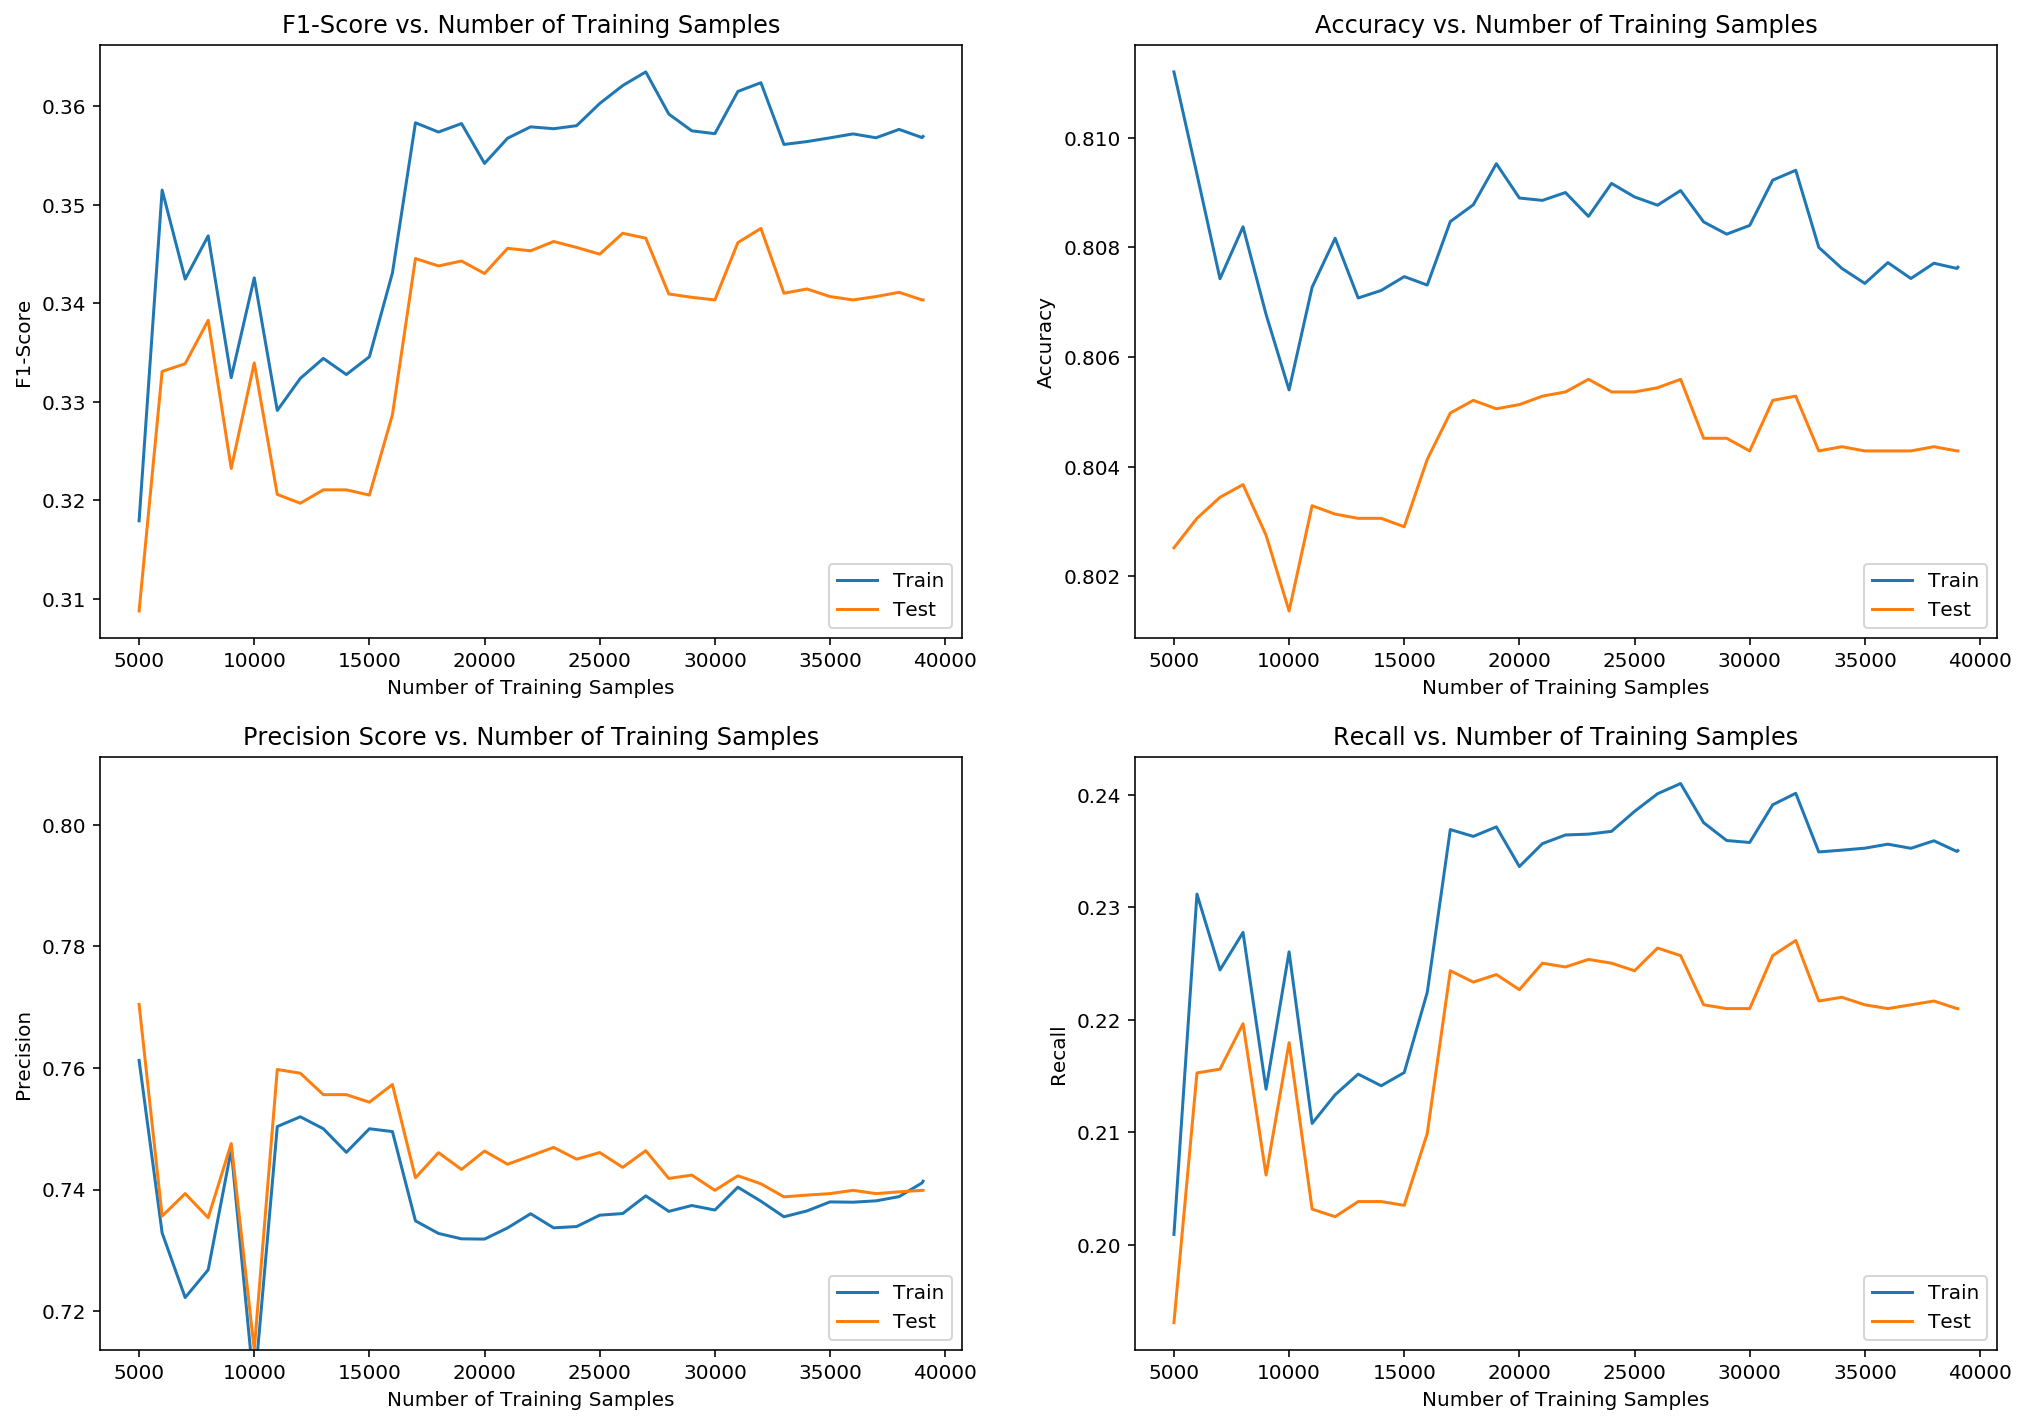

In [56]:
xtrain,xtest,ytrain,ytest = train_test_split(X_headline_tfidf,y)

cv = cross_validation(lr_headline, xtrain, ytrain , n_splits=5,init_chunk_size = 5000, chunk_spacings = 1000, average = "binary")
cv.validate_for_holdout_set(xtest, ytest)
cv.plot_learning_curve()

# Logistic Regression
##### Using Body of the article

In [57]:
lr_body = LogisticRegression(penalty='l1')

In [59]:
# train model
lr_body.fit(X_body_tfidf_train, y_body_train)

# get predictions for article section
y_body_pred = lr_body.predict(X_body_tfidf_test)

In [60]:
# print metrics
print "Logistig Regression F1 and Accuracy Scores : \n"
print ( "F1 score {:.4}%".format( f1_score(y_body_test, y_body_pred, average='macro')*100 ) )
print ( "Accuracy score {:.4}%".format(accuracy_score(y_body_test, y_body_pred)*100) )

Logistig Regression F1 and Accuracy Scores : 

F1 score 95.31%
Accuracy score 96.79%


In [61]:
cros_val_list = cross_val_score(lr_body, X_body_tfidf,y,cv=7)
print cros_val_list
print cros_val_list.mean()

[ 0.93115504  0.96598091  0.97135942  0.95656267  0.96422808  0.96422808
  0.96530393]
0.959831159315


### Learning Curve for body logistic regression

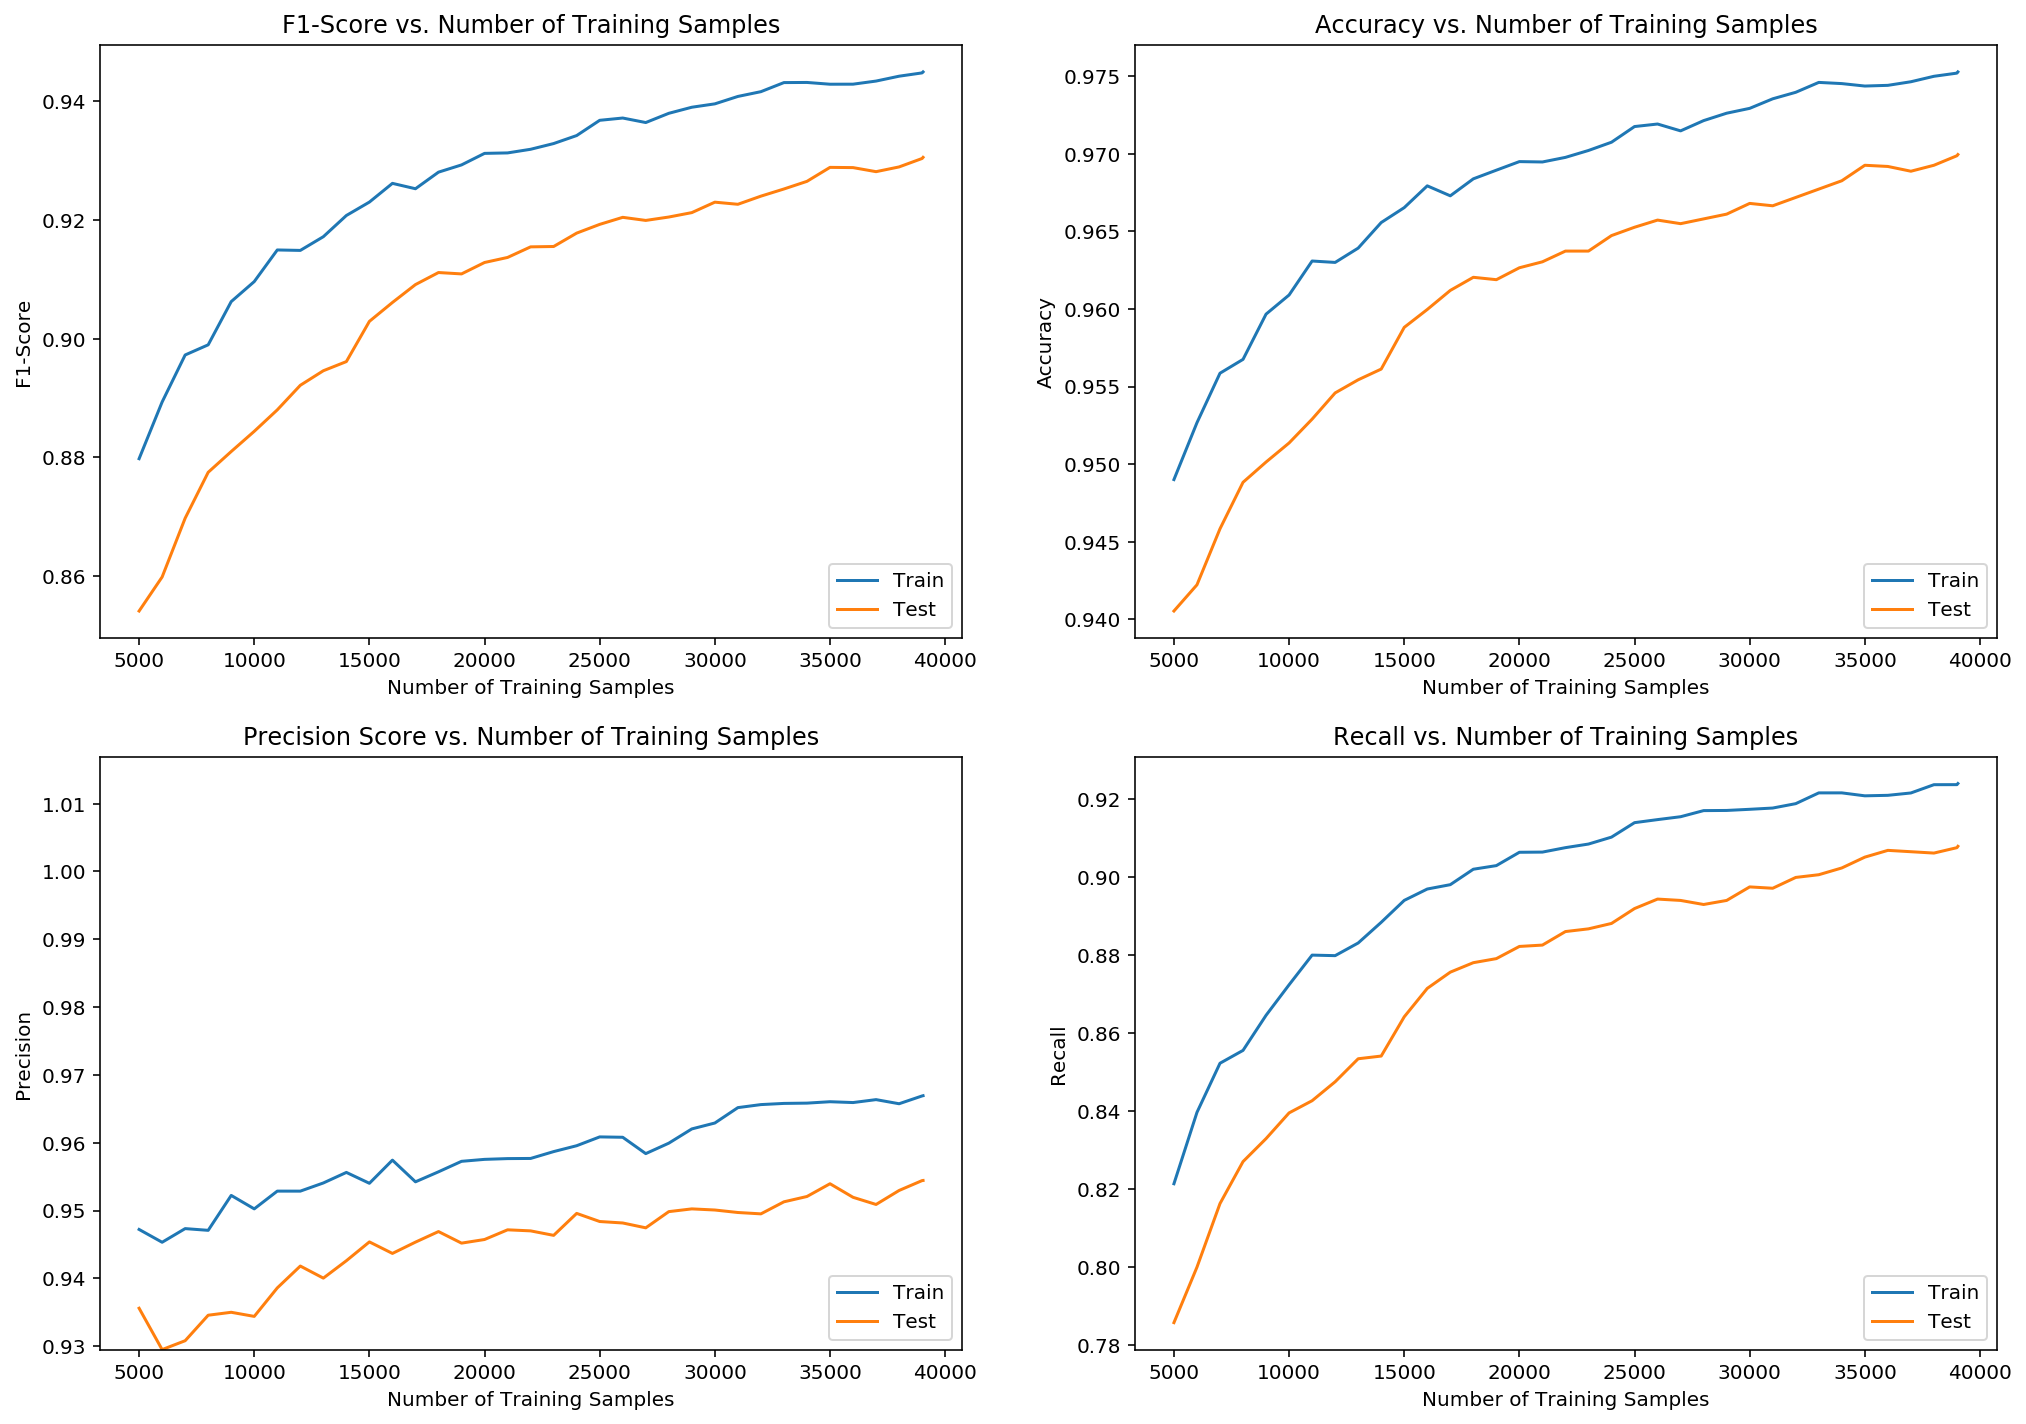

In [62]:
xtrain,xtest,ytrain,ytest = train_test_split(X_body_tfidf,y)

cv = cross_validation(lr_headline, xtrain, ytrain , n_splits=5,init_chunk_size = 5000, chunk_spacings = 1000, average = "binary")
cv.validate_for_holdout_set(xtest, ytest)
cv.plot_learning_curve()

# Random Forest
##### Using headlines from the dataset

In [66]:
rcf_headline = RandomForestClassifier(n_estimators=100,n_jobs=3)

In [68]:
rcf_headline.fit(X_headline_tfidf_train, y_headline_train)
y_rc_headline_pred = rcf_headline.predict(X_headline_tfidf_test)

In [69]:
# print metrics
print "Random Forest F1 and Accuracy Scores : \n"
print ( "F1 score {:.4}%".format( f1_score(y_headline_test, y_rc_headline_pred, average='macro')*100 ) )
print ( "Accuracy score {:.4}%".format(accuracy_score(y_headline_test, y_rc_headline_pred)*100) )

Random Forest F1 and Accuracy Scores : 

F1 score 63.36%
Accuracy score 81.34%


In [71]:
cros_val_list = cross_val_score(rcf_headline, X_headline_tfidf,y,cv=5)
print cros_val_list
print cros_val_list.mean()

[ 0.7889732   0.81788493  0.7869561   0.81769282  0.81922966]
0.806147344155


### Learning Curve for headline random forest

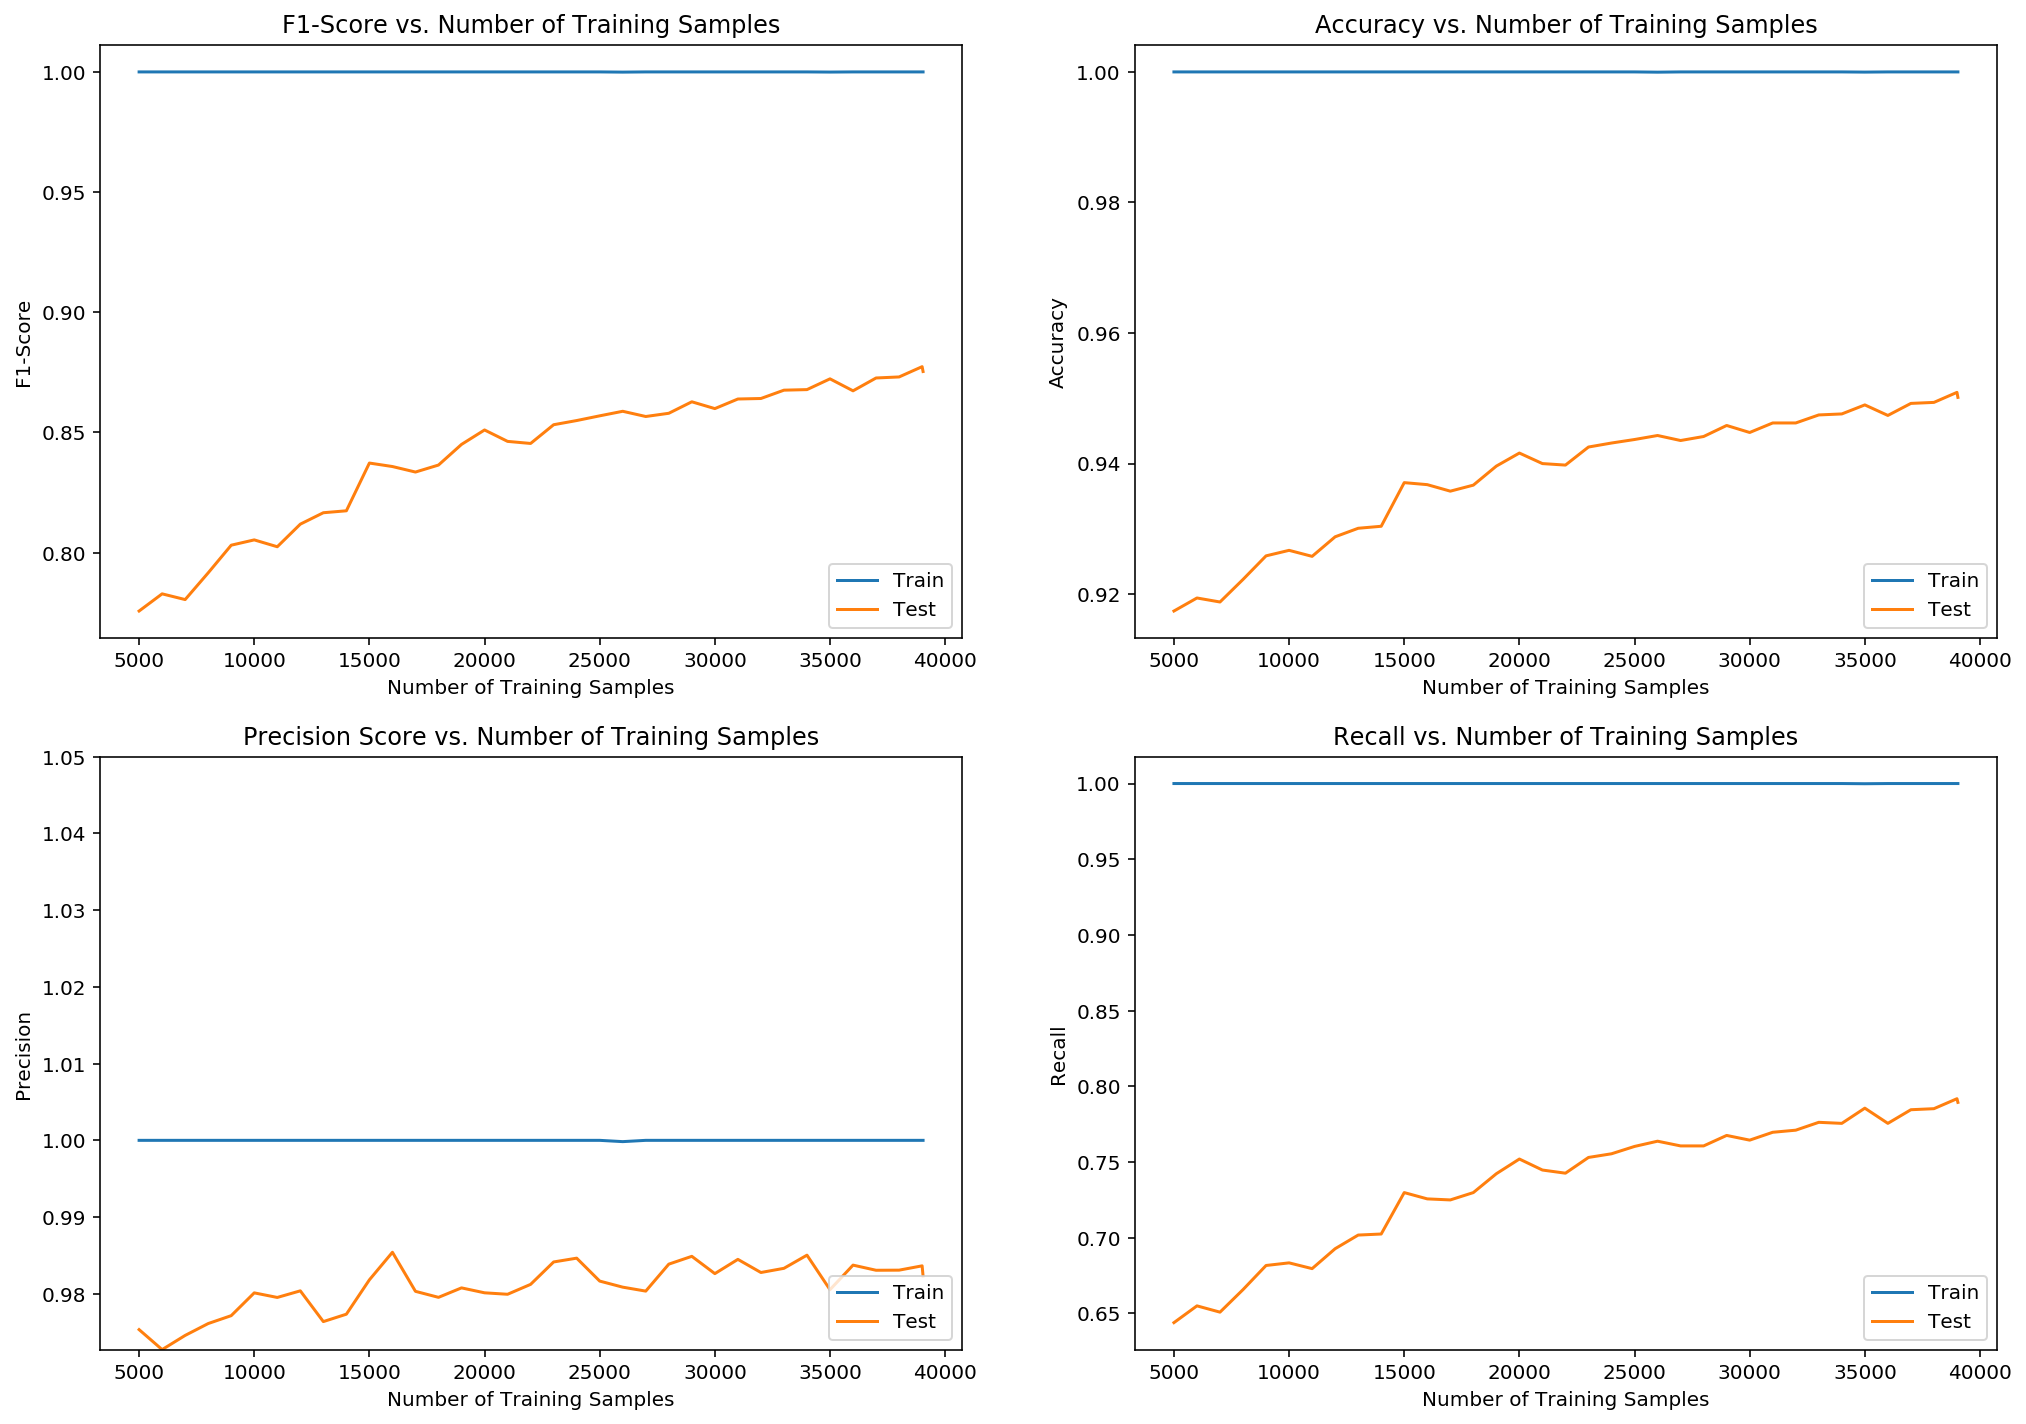

In [72]:
xtrain,xtest,ytrain,ytest = train_test_split(X_headline_tfidf,y)

cv = cross_validation(rcf_headline, xtrain, ytrain , n_splits=5,init_chunk_size = 5000, chunk_spacings = 1000, average = "binary")
cv.validate_for_holdout_set(xtest, ytest)
cv.plot_learning_curve()

# Random Forest
##### Using body from the dataset

In [ ]:
rcf_body = RandomForestClassifier(n_estimators=100,n_jobs=3)

In [ ]:
rcf_body.fit(X_body_tfidf_train, y_body_train)
y_rc_body_pred = rcf_body.predict(X_body_tfidf_test)

In [ ]:
# print metrics
print "Random Forest F1 and Accuracy Scores : \n"
print ( "F1 score {:.4}%".format( f1_score(y_body_test, y_rc_body_pred, average='macro')*100 ) )
print ( "Accuracy score {:.4}%".format(accuracy_score(y_body_test, y_rc_body_pred)*100) )

### Learning Curve for body random forest

In [ ]:
xtrain,xtest,ytrain,ytest = train_test_split(X_body_tfidf,y)

cv = cross_validation(rcf_body, xtrain, ytrain , n_splits=5,init_chunk_size = 5000, chunk_spacings = 1000, average = "binary")
cv.validate_for_holdout_set(xtest, ytest)
cv.plot_learning_curve()

# XGBoost Classifier
##### Using headlines from the dataset

In [22]:
xgb_headline = XGBClassifier()

In [24]:
xgb_headline.fit(X_headline_tfidf_train, y_headline_train)
y_xgb_headline_pred = xgb_headline.predict(X_headline_tfidf_test)

In [25]:
# print metrics
print "XGBoost F1 and Accuracy Scores : \n"
print ( "F1 score {:.4}%".format( f1_score(y_headline_test, y_xgb_headline_pred, average='macro')*100 ) )
print ( "Accuracy score {:.4}%".format(accuracy_score(y_headline_test, y_xgb_headline_pred)*100) )

XGBoost F1 and Accuracy Scores : 

F1 score 61.22%
Accuracy score 81.09%


### Learning Curve for headline XGboost

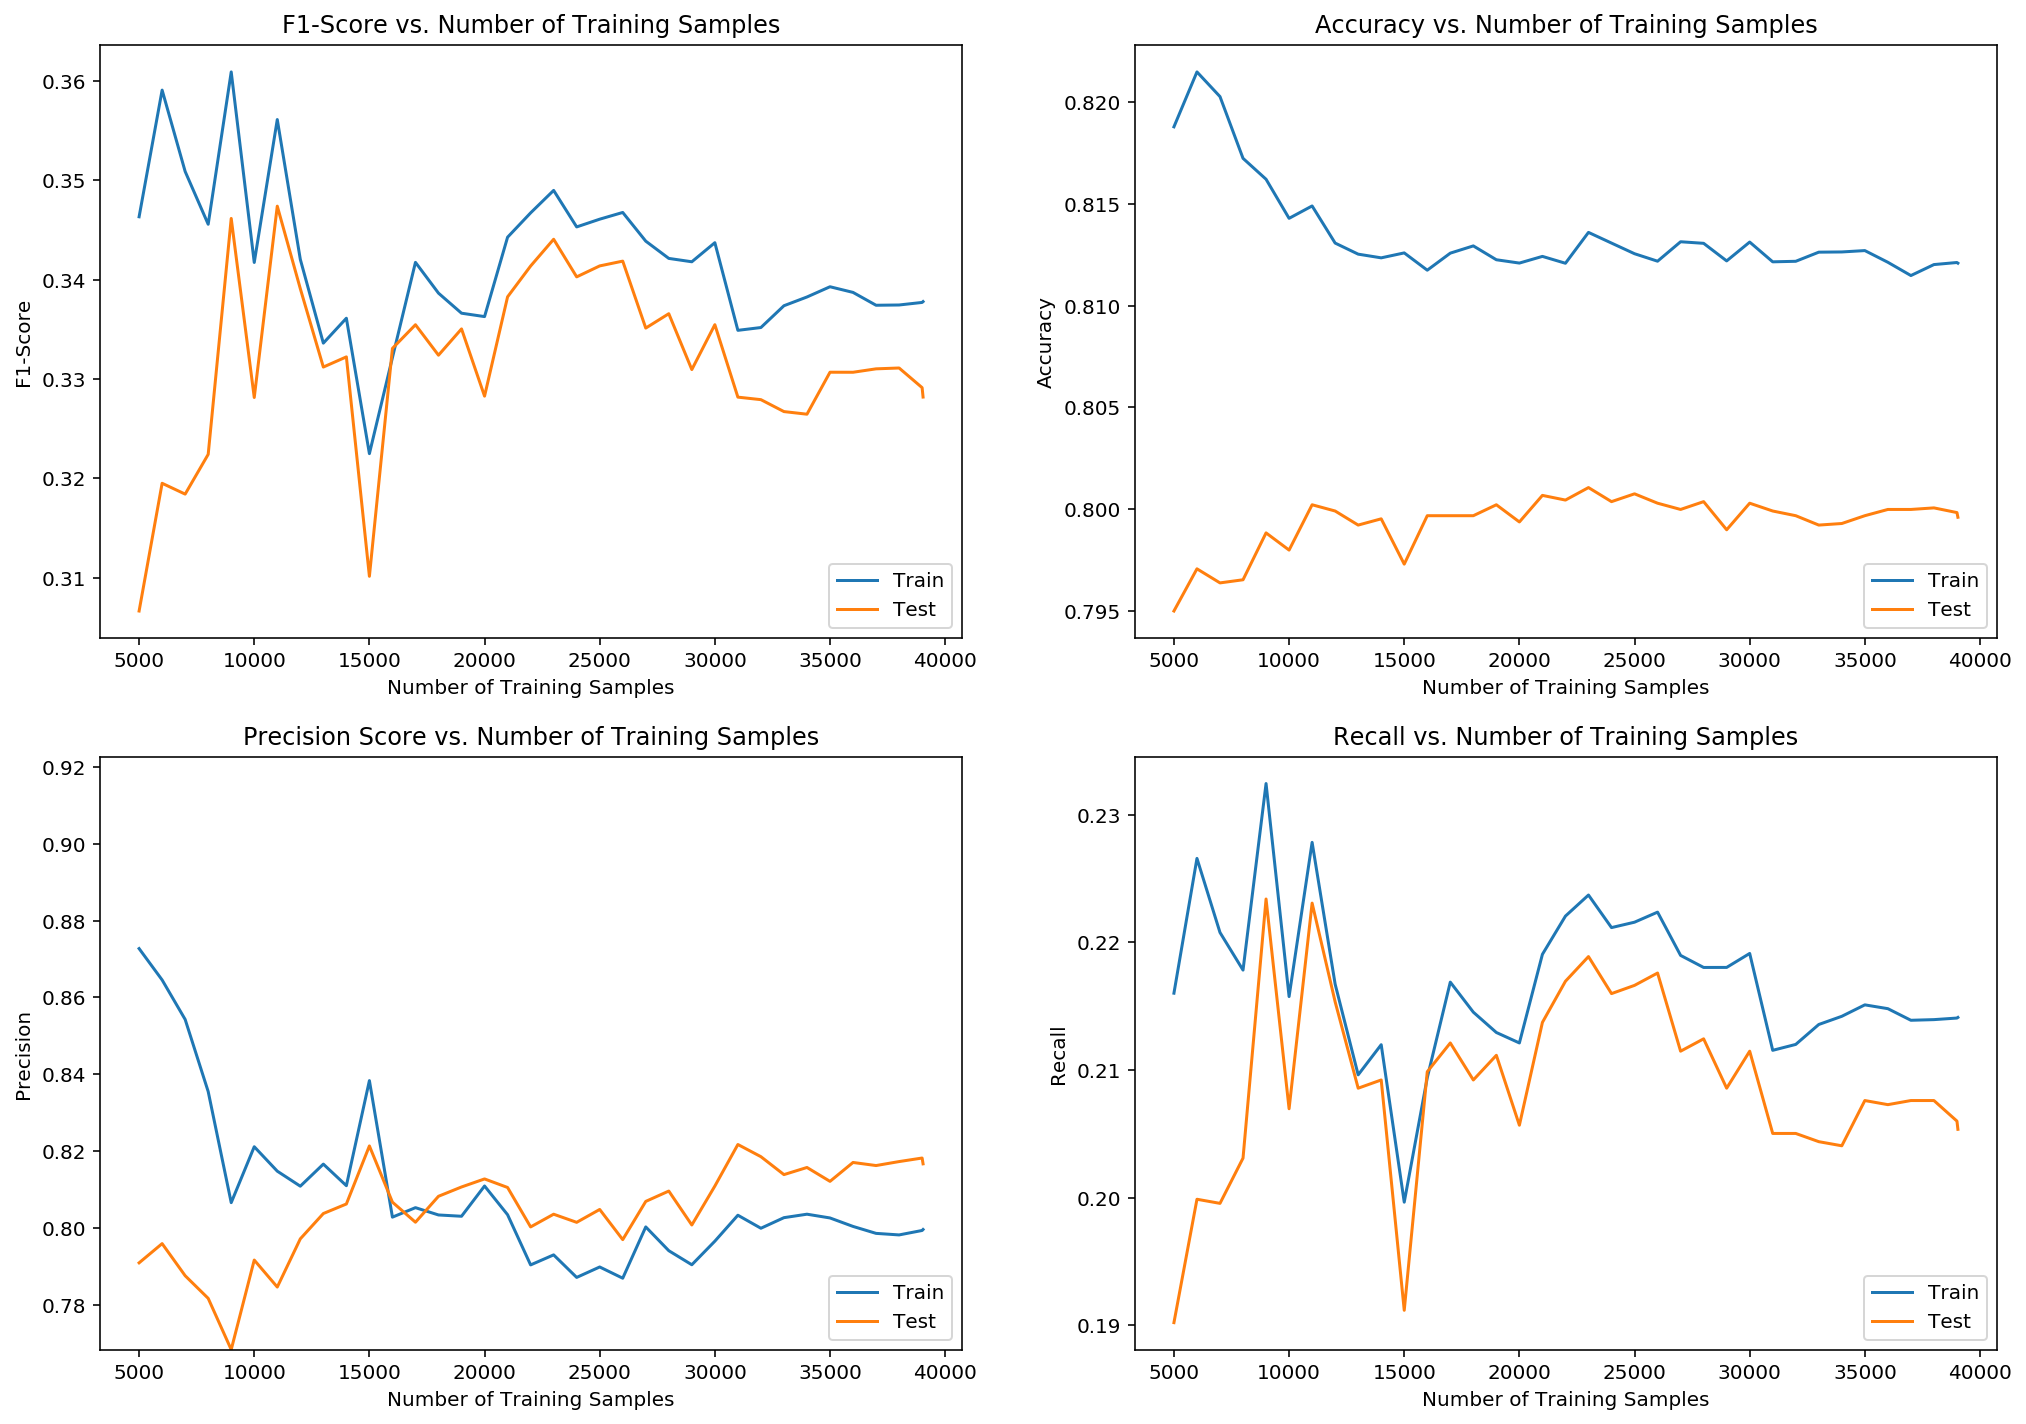

In [27]:
xtrain,xtest,ytrain,ytest = train_test_split(X_headline_tfidf,y)

cv = cross_validation(xgb_headline, xtrain, ytrain , n_splits=5,init_chunk_size = 5000, chunk_spacings = 1000, average = "binary")
cv.validate_for_holdout_set(xtest, ytest)
cv.plot_learning_curve()

# XGBoost Classifier
##### Using body from the dataset

In [ ]:
xgb_body = XGBClassifier()

In [ ]:
xgb_body.fit(X_body_train_tfidf, y_body_train)
y_xgb_body_pred = xgb_body.predict(X_body_test_tfidf)

In [ ]:
# print metrics
print "XGBoost F1 and Accuracy Scores : \n"
print ( "F1 score {:.4}%``".format( f1_score(y_body_test, y_xgb_body_pred, average='macro')*100 ) )
print ( "Accuracy score {:.4}%".format(accuracy_score(y_body_test, y_xgb_body_pred)*100) )

### Learning Curve for body XGboost

In [ ]:
xtrain,xtest,ytrain,ytest = train_test_split(X_body_tfidf,y)

cv = cross_validation(xgb_body, xtrain, ytrain , n_splits=5,init_chunk_size = 5000, chunk_spacings = 1000, average = "binary")
cv.validate_for_holdout_set(xtest, ytest)
cv.plot_learning_curve()